In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])

GLOBAL_KEY = jax.random.key(42)

In [2]:
from gymnasium.envs.registration import register
from envs.mujoco.online_env_utils import make_online_env
from envs.mujoco.ant import AntEnv

register(
    id='myant',
    entry_point=AntEnv,
    max_episode_steps=256,
    reward_threshold=-3.75,
)

env = make_online_env("myant", default_ind=2)
env.reset()

(array([ 0.71107104,  0.94418304,  0.03014035, -0.04211561, -0.01093633,
         0.08472774, -0.03824342,  0.08014395, -0.09544288, -0.04409646,
         0.06788984, -0.00550396, -0.09301253,  0.06776115,  0.08339567,
         0.01845545,  0.04552969,  0.12071088, -0.08010211, -0.04056672,
         0.00105999, -0.04744596, -0.10238868,  0.09871621,  0.11368628,
        -0.00416119,  0.09836764,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import functools
from utils.datasets import Dataset, GCDataset

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

selected_keys = ["observation", "next_observation", "actions", "done", "reward"]

whole_data = []
for i in range(10):
    cur_data = np.load(f"/home/m_bobrin/ZeroShotRL/envs/mujoco/data_custom_ant/default_ind_{i}.npz", allow_pickle=True)
    data = {key: cur_data[key] for key in selected_keys if key in cur_data.files}
    data['observations'] = data['observation']
    data['next_observations'] = data['next_observation']
    data['rewards'] = data['reward']
    del data['observation']
    del data['next_observation']
    del data['reward']
    whole_data.append(data)

whole_data = functools.reduce(concatenate_dicts, whole_data)
pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

{
│   'actions': (2000, 256, 8),
│   'done': (2000, 256),
│   'next_observations': (2000, 256, 105),
│   'observations': (2000, 256, 105),
│   'rewards': (2000, 256)
}

In [ ]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction
from utils.flax_utils import TrainState, ModuleDict
import optax
from sklearn.manifold import TSNE

example_batch = whole_dataset.sample(1)
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
dynamics_def = DynamicsTransformer(
    num_layers=2,
    num_heads=2,
    out_dim=8,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=64,
    mlp_dim=128,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=256
)
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0), optax.adam(learning_rate=1e-4))
network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                    example_batch['observations'], True))
            )
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'], jnp.zeros((1, 256, 8))))
)
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

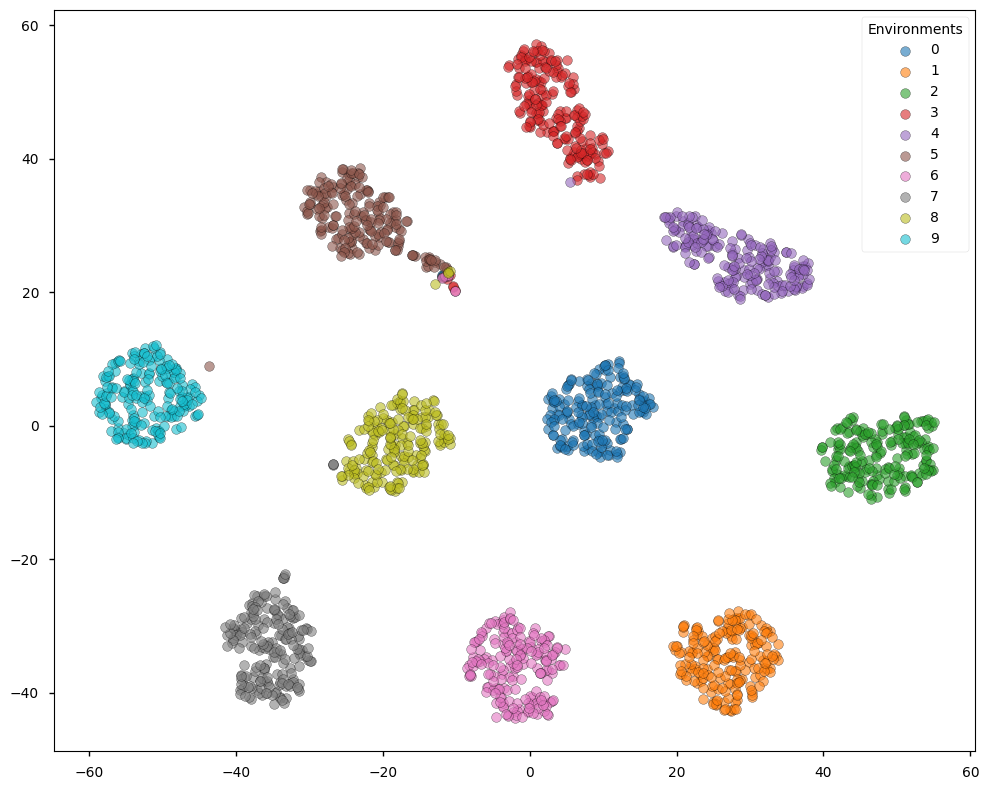

In [ ]:
from IPython.display import clear_output

def context_encoder_loss(agent, batch, grad_params):
    dynamics_embedding = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    # dynamics_embedding = dynamics_embedding / jax.lax.stop_gradient(jnp.linalg.norm(dynamics_embedding, axis=1, keepdims=True))
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    return loss, {"context_embedding_loss": loss}

@jax.jit
def update(agent, batch):
    def loss_fn(grad_params):
        # dyn_loss = context_encoder_loss(agent, batch, grad_params)
        return context_encoder_loss(agent, batch, grad_params)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

num_environments = 10
samples_per_env = 200

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)

pbar = tqdm(range(50_000))
for i in pbar:
    batch = whole_dataset.sample(32)
    network, info = update(network, batch)
    
    if i % 5_000 == 0:
        clear_output()
        dynamics_embedding = network.select('dynamic_transformer')(whole_data['observations'], whole_data['actions'],
                                                                            whole_data['next_observations'], train=False)
        tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(num_environments):
            mask = (env_indices == i)
            ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                        color=plt.cm.tab10(i), 
                        edgecolors='black',
                        label=i,
                        alpha=0.6)

        ax.legend(title="Environments")
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [ ]:
# batch = whole_dataset.sample(1)
dynamics_embedding = network.select('dynamic_transformer')(whole_data['observations'], whole_data['actions'],
                                                                            whole_data['next_observations'], train=False)
# dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
# next_state_pred = network.select('next_state_pred')(whole_data['observations'], whole_data['actions'], dynamics_embedding)

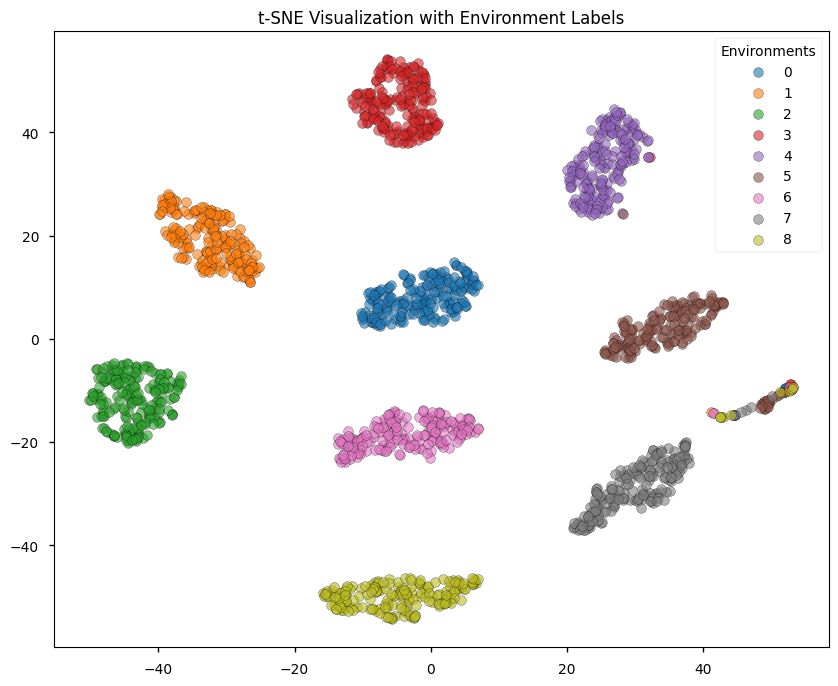

In [ ]:
from sklearn.manifold import TSNE

num_environments = 9
samples_per_env = 200

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)
tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)

plt.figure(figsize=(10, 8))
for i in range(num_environments):
    mask = (env_indices == i)
    plt.scatter(tsne[mask, 0], tsne[mask, 1], 
                color=plt.cm.tab10(i), 
                edgecolors='black',
                label=i,
                alpha=0.6)

plt.legend(title="Environments")
plt.title("t-SNE Visualization with Environment Labels")
plt.show()

In [ ]:
from gymnasium.envs.registration import register
from envs.mujoco.online_env_utils import make_online_env
from envs.mujoco.ant import AntEnv

register(
    id='myant',
    entry_point=AntEnv,
    max_episode_steps=256,
    reward_threshold=-3.75,
)

env = make_online_env("myant", default_ind=3)
env.reset()

